Sources:

https://github.com/Coding-Crashkurse/RAG-Evaluation-with-Ragas/blob/main/ragas.ipynb
https://www.youtube.com/watch?v=aeae-sITqEA

Youtube Link:
https://www.youtube.com/watch?v=aeae-sITqEA

In [1]:
from langchain_community.document_loaders import PyPDFDirectoryLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
data_path = "."

print("Loading directory...")
# pdf_loader = PyPDFDirectoryLoader(path=data_path, glob="**/*.pdf", recursive=True)
pdf_loader = PyPDFDirectoryLoader(path=data_path, glob="*.pdf", recursive=True)
documents = pdf_loader.load()

for document in documents:
  document.metadata['file_name'] = document.metadata['source']

print("Directory loaded...")
print("Documents length:", len(documents))

print("Splitting text...")
# Initialize the RecursiveCharacterTextSplitter for splitting text
# predefined length -- how many chars do we want per chunk
# overlap - character 0 - 1000, first document. Then, there's an overlap of +-150 characters between doc 1 and doc 2
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=50)
chunked_documents = text_splitter.split_documents(documents)

# Remove the bibiography of each PDF ?? Maybe not needed
print('Length of chunks:', len(chunked_documents))

Loading directory...
Directory loaded...
Documents length: 4
Splitting text...
Length of chunks: 11


In [2]:

from ragas.testset.generator import TestsetGenerator
from ragas.testset.evolutions import simple, reasoning, multi_context

generator = TestsetGenerator.with_openai()

generator_llm = "gpt-3.5-turbo-0125"
critic_llm = "gpt-4-turbo"
embeddings = "text-embedding-ada-002"

generator = TestsetGenerator.with_openai(
    generator_llm,
    critic_llm,
    embeddings
)

distributions = {
    simple: 0.5,
    reasoning: 0.25,
    multi_context: 0.25
}

# distributions = {
#     simple: 0.5,
#     multi_context: 0.4,
#     reasoning: 0.1
# }

# generate testset
testset = generator.generate_with_langchain_docs(chunked_documents, test_size=10, distributions=distributions)

c:\Users\louis\Desktop\thesis-chatbot\env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Generating: 100%|██████████| 10/10 [01:34<00:00,  9.42s/it]     


In [3]:
testset.to_pandas()

,question,contexts,ground_truth,evolution_type,episode_done
0,"""How does Streamlit simplify the deployment of...",[frameworks like HTML and CSS. With Streamlit...,Streamlit simplifies the deployment of models ...,simple,True
1,"""How does Streamlit facilitate rapid prototypi...","[Seaborn, Scikit -learn and TensorFlow, which ...",Streamlit facilitates rapid prototyping by all...,simple,True
2,"""How does LangChain utilize Large Language Mod...",[LangChain increase overal l efficiency and ma...,LangChain utilizes Large Language Models to re...,simple,True
3,"""How does LangChain utilize Large Language Mod...",[LangChain increase overal l efficiency and ma...,LangChain utilizes Large Language Models to im...,simple,True
4,"""How does Streamlit's user-friendly interface ...","[Seaborn, Scikit -learn and TensorFlow, which ...",Streamlit's user-friendly interface requires l...,simple,True
5,How does LangChain leverage Large Language Mod...,[LangChain increase overal l efficiency and ma...,LangChain leverages Large Language Models (LLM...,reasoning,True
6,"""How do Seaborn, Scikit-learn, and TensorFlow ...","[Seaborn, Scikit -learn and TensorFlow, which ...",,reasoning,True
7,"""How does Streamlit help in developing data ap...","[Seaborn, Scikit -learn and TensorFlow, which ...",,multi_context,True
8,"""How do Streamlit's features help with rapid p...","[Seaborn, Scikit -learn and TensorFlow, which ...",Streamlit's features help with rapid prototypi...,multi_context,True
9,"""How does LangChain utilize Large Language Mod...",[LangChain increase overal l efficiency and ma...,LangChain utilizes Large Language Models to im...,simple,True


In [6]:
testset.to_pandas().to_csv('data.csv', index=False)

In [4]:
from langchain_openai.embeddings import OpenAIEmbeddings
index_name="ics-chatbot-ai"

embeddings = OpenAIEmbeddings()

from langchain_pinecone import PineconeVectorStore

pinecone = PineconeVectorStore.from_documents(
  documents=chunked_documents, embedding=embeddings, index_name=index_name
)

retriever = pinecone.as_retriever()

In [13]:
from search_prompts import SearchPrompts
prompt = SearchPrompts.answer_query_prompt()
print("Done loading prompt")

Done loading prompt


In [18]:
import os
from dotenv import load_dotenv
load_dotenv()
openai_api_key=os.environ["OPENAI_API_KEY"]

from langchain_core.output_parsers import StrOutputParser
from langchain.chains.qa_with_sources.retrieval import RetrievalQAWithSourcesChain 

parser=StrOutputParser()
from langchain_openai.chat_models import ChatOpenAI

model = ChatOpenAI(openai_api_key=openai_api_key, model=generator_llm, temperature=0)

chain = RetrievalQAWithSourcesChain.from_chain_type(
    llm=model,
    chain_type="stuff",
    retriever=retriever,
    chain_type_kwargs={
        "prompt": prompt,
    },
    verbose=True,
)

In [19]:
docs = retriever.get_relevant_documents(query)

inputs = {"question":"How does Streamlit simplify the deployment of models using frameworks like HTML and CSS, and how does it assist in handling PDF files in the querying process?", "topic":"Artificial Intelligence", "summaries": retriever}
res = chain.invoke(inputs)




> Entering new RetrievalQAWithSourcesChain chain...

> Finished chain.


In [20]:
res

{'question': 'How does Streamlit simplify the deployment of models using frameworks like HTML and CSS, and how does it assist in handling PDF files in the querying process?',
 'topic': 'Artificial Intelligence',
 'summaries': VectorStoreRetriever(tags=['PineconeVectorStore', 'OpenAIEmbeddings'], vectorstore=<langchain_pinecone.vectorstores.PineconeVectorStore object at 0x000001D3C52960E0>),
 'answer': 'Streamlit simplifies the deployment of models using frameworks like HTML and CSS by providing an open-source library that allows for the creation of unique web apps for Machine Learning and Data Science projects efficiently. With Streamlit, users can easily build interactive visualization plots, models, and dashboards without worrying about the underlying web framework or deployment infrastructure. Additionally, Streamlit allows users to add widgets to interact with the web app and the models used, making the deployment process smoother and more user-friendly.\n\nIn handling PDF files in

In [35]:
res['answer']

'Streamlit simplifies the deployment of models using frameworks like HTML and CSS by providing an open-source library that allows for the creation of unique web apps for Machine Learning and Data Science projects efficiently. With Streamlit, users can easily build interactive visualization plots, models, and dashboards without worrying about the underlying web framework or deployment infrastructure. Additionally, Streamlit allows users to add widgets to interact with the web app and the models used, making the deployment process smoother and more user-friendly.\n\nIn handling PDF files in the querying process, Streamlit assists by taking care of the front-end part of the application where text inputs, messages, and PDF files from the user are managed. This integration simplifies the process of extracting information from PDF files based on the prompt sent by the user, enhancing the overall querying experience.\n\nReferences:\n[1] '

In [37]:
from datasets import Dataset

questions = testset.to_pandas()["question"].to_list()
ground_truth = testset.to_pandas()["ground_truth"].to_list()

data = {"question": [], "answer": [], "contexts": [], "ground_truth": ground_truth}

for query in questions:
    print("query", query)
    docs = retriever.get_relevant_documents(query)
    inputs = {"question":query, "topic":"Artificial Intelligence", "summaries": docs}
    answer = chain.invoke(inputs)['answer']

    data["question"].append(query)
    data["answer"].append(answer)
    data["contexts"].append([doc.page_content for doc in docs])

dataset = Dataset.from_dict(data)

query "How does Streamlit simplify the deployment of models using frameworks like HTML and CSS, and how does it assist in handling PDF files in the querying process?"


ArrowInvalid: Column 3 named ground_truth expected length 0 but got length 10

In [34]:
data

{'question': ['"How does Streamlit simplify the deployment of models using frameworks like HTML and CSS, and how does it assist in handling PDF files in the querying process?"',
  '"How does Streamlit facilitate rapid prototyping and real-time collaboration for developers and data scientists using Seaborn, Scikit-learn, and TensorFlow?"',
  '"How does LangChain utilize Large Language Models to revolutionize Natural Language Processing and simplify PDF querying?"',
  '"How does LangChain utilize Large Language Models to improve the querying process and extraction of information from PDFs?"',
  '"How does Streamlit\'s user-friendly interface make it easy for developers and data scientists to build dynamic data apps?"',
  'How does LangChain leverage Large Language Models to enhance the process of querying and extracting information from PDFs, ultimately simplifying the search and retrieval of documents?',
  '"How do Seaborn, Scikit-learn, and TensorFlow aid in the rapid prototyping and d

In [31]:
dataset

Dataset({
    features: ['question', 'answer', 'contexts', 'ground_truth'],
    num_rows: 10
})

In [38]:
from ragas import evaluate
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    context_relevancy,
    context_recall,
    context_precision,
)

result = evaluate(
    dataset = dataset,
    metrics=[
        context_relevancy,
        context_precision,
        context_recall,
        faithfulness,
        answer_relevancy,
    ],
    raise_exceptions=False
)

Evaluating:  14%|█▍        | 7/50 [00:10<00:40,  1.07it/s]Runner in Executor raised an exception
Traceback (most recent call last):
  File "c:\Users\louis\Desktop\thesis-chatbot\env\lib\site-packages\ragas\executor.py", line 58, in _aresults
    r = await future
  File "C:\Users\louis\miniconda3\lib\asyncio\tasks.py", line 571, in _wait_for_one
    return f.result()  # May raise f.exception().
  File "c:\Users\louis\Desktop\thesis-chatbot\env\lib\site-packages\ragas\executor.py", line 91, in wrapped_callable_async
    return counter, await callable(*args, **kwargs)
  File "c:\Users\louis\Desktop\thesis-chatbot\env\lib\site-packages\ragas\metrics\base.py", line 91, in ascore
    raise e
  File "c:\Users\louis\Desktop\thesis-chatbot\env\lib\site-packages\ragas\metrics\base.py", line 87, in ascore
    score = await self._ascore(row=row, callbacks=group_cm, is_async=is_async)
  File "c:\Users\louis\Desktop\thesis-chatbot\env\lib\site-packages\ragas\metrics\_faithfulness.py", line 190, in _

In [39]:
result.to_pandas()

,question,answer,contexts,ground_truth,context_relevancy,context_precision,context_recall,faithfulness,answer_relevancy
0,"""How does Streamlit simplify the deployment of...",Streamlit simplifies the deployment of models ...,[Model helps the user to get the accurate resu...,Streamlit simplifies the deployment of models ...,NaN,0.068182,0.0,1.0,0.800000
1,"""How does Streamlit facilitate rapid prototypi...",Streamlit facilitates rapid prototyping and re...,"[Seaborn, Scikit -learn and TensorFlow, which ...",Streamlit facilitates rapid prototyping by all...,0.902234,0.012195,1.0,1.0,1.000000
2,"""How does LangChain utilize Large Language Mod...",LangChain utilizes Large Language Models (LLMs...,[An Ef fective Query System Using LLMs and \nL...,LangChain utilizes Large Language Models to re...,0.882238,0.011111,1.0,1.0,0.600000
3,"""How does LangChain utilize Large Language Mod...",LangChain utilizes Large Language Models (LLMs...,[An Ef fective Query System Using LLMs and \nL...,LangChain utilizes Large Language Models to im...,0.832129,0.011111,1.0,1.0,0.600000
4,"""How does Streamlit's user-friendly interface ...",Streamlit's user-friendly interface makes it e...,[Model helps the user to get the accurate resu...,Streamlit's user-friendly interface requires l...,0.918817,0.048780,1.0,1.0,1.000000
5,How does LangChain leverage Large Language Mod...,LangChain leverages Large Language Models (LLM...,[LangChain increase overal l efficiency and ma...,LangChain leverages Large Language Models (LLM...,0.887271,0.077778,1.0,1.0,1.000000
6,"""How do Seaborn, Scikit-learn, and TensorFlow ...","Seaborn, Scikit-learn, and TensorFlow play cru...","[Seaborn, Scikit -learn and TensorFlow, which ...",,0.952058,0.012195,0.0,1.0,1.000000
7,"""How does Streamlit help in developing data ap...",Streamlit helps in developing data apps with T...,[Model helps the user to get the accurate resu...,,0.867223,0.060976,0.0,1.0,0.833333
8,"""How do Streamlit's features help with rapid p...",Streamlit's features greatly aid in rapid prot...,"[Seaborn, Scikit -learn and TensorFlow, which ...",Streamlit's features help with rapid prototypi...,0.872798,0.012195,1.0,1.0,1.000000
9,"""How does LangChain utilize Large Language Mod...",LangChain utilizes Large Language Models (LLMs...,[LangChain increase overal l efficiency and ma...,LangChain utilizes Large Language Models to im...,0.895237,0.035714,1.0,1.0,0.918337


In [40]:
result.to_pandas().to_csv('data_with_scores.csv', index=False)

In [2]:
import pandas as pd

df = pd.read_csv('data_with_scores.csv')

df


,question,answer,contexts,ground_truth,context_relevancy,context_precision,context_recall,faithfulness,answer_relevancy
0,"""How does Streamlit simplify the deployment of...",Streamlit simplifies the deployment of models ...,['Model helps the user to get the accurate res...,Streamlit simplifies the deployment of models ...,NaN,0.068182,0.0,1.0,0.800000
1,"""How does Streamlit facilitate rapid prototypi...",Streamlit facilitates rapid prototyping and re...,"['Seaborn, Scikit -learn and TensorFlow, which...",Streamlit facilitates rapid prototyping by all...,0.902234,0.012195,1.0,1.0,1.000000
2,"""How does LangChain utilize Large Language Mod...",LangChain utilizes Large Language Models (LLMs...,['An Ef fective Query System Using LLMs and \n...,LangChain utilizes Large Language Models to re...,0.882238,0.011111,1.0,1.0,0.600000
3,"""How does LangChain utilize Large Language Mod...",LangChain utilizes Large Language Models (LLMs...,['An Ef fective Query System Using LLMs and \n...,LangChain utilizes Large Language Models to im...,0.832129,0.011111,1.0,1.0,0.600000
4,"""How does Streamlit's user-friendly interface ...",Streamlit's user-friendly interface makes it e...,['Model helps the user to get the accurate res...,Streamlit's user-friendly interface requires l...,0.918817,0.048780,1.0,1.0,1.000000
5,How does LangChain leverage Large Language Mod...,LangChain leverages Large Language Models (LLM...,['LangChain increase overal l efficiency and m...,LangChain leverages Large Language Models (LLM...,0.887271,0.077778,1.0,1.0,1.000000
6,"""How do Seaborn, Scikit-learn, and TensorFlow ...","Seaborn, Scikit-learn, and TensorFlow play cru...","['Seaborn, Scikit -learn and TensorFlow, which...",NaN,0.952058,0.012195,0.0,1.0,1.000000
7,"""How does Streamlit help in developing data ap...",Streamlit helps in developing data apps with T...,['Model helps the user to get the accurate res...,NaN,0.867223,0.060976,0.0,1.0,0.833333
8,"""How do Streamlit's features help with rapid p...",Streamlit's features greatly aid in rapid prot...,"['Seaborn, Scikit -learn and TensorFlow, which...",Streamlit's features help with rapid prototypi...,0.872798,0.012195,1.0,1.0,1.000000
9,"""How does LangChain utilize Large Language Mod...",LangChain utilizes Large Language Models (LLMs...,['LangChain increase overal l efficiency and m...,LangChain utilizes Large Language Models to im...,0.895237,0.035714,1.0,1.0,0.918337


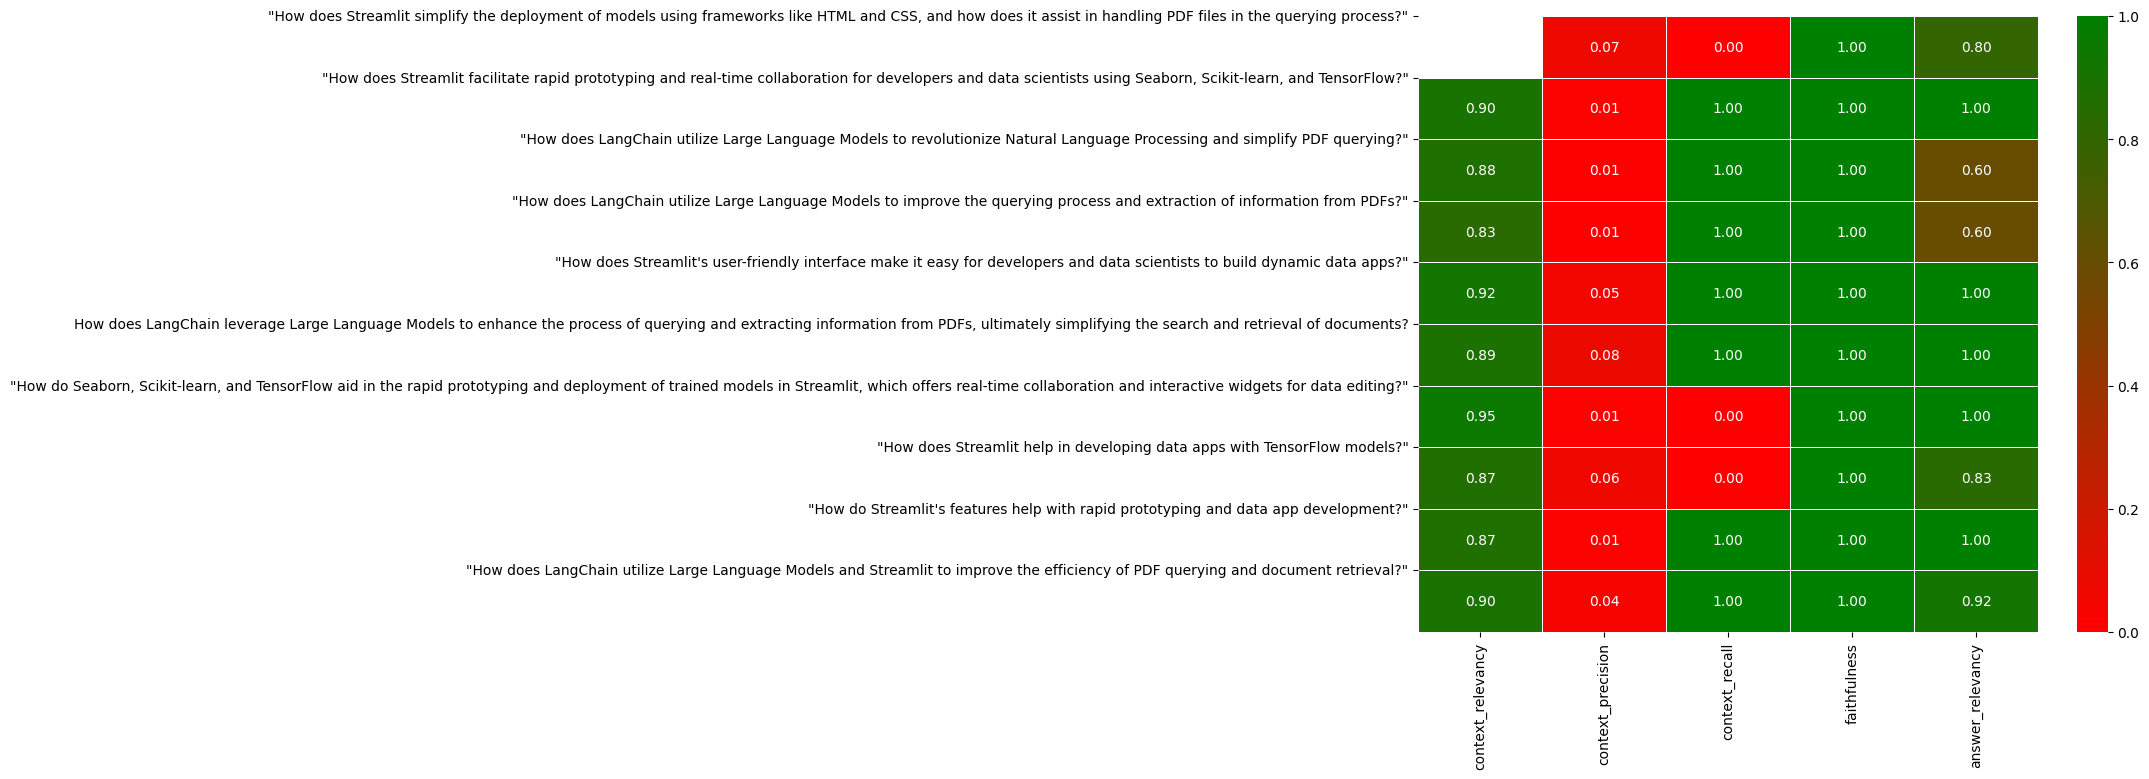

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# only use if not reading saved csv

# df = result.to_pandas()

heatmap_data = df[['context_relevancy', 'context_precision', 'context_recall', 'faithfulness', 'answer_relevancy']]

cmap = LinearSegmentedColormap.from_list('green_red', ['red', 'green'])

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", linewidths=.5, cmap=cmap)

plt.yticks(ticks=range(len(df['question'])), labels=df['question'], rotation=0)

plt.show()